### Load libs

In [ ]:
# ml
from sklearn import metrics
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve,roc_auc_score
import pickle

# standard
import pandas as pd
import numpy as np
import json
import pickle
import os

# plotting
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# set plot size
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi']

n = 500
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', n)
pd.set_option('display.max_columns', n)

### Load data

In [ ]:
folder = '/content/drive/MyDrive/Loan_default/splits/'

In [ ]:
init_train = pd.read_csv(folder + 'train_outcome.csv')
init_val = pd.read_csv(folder + 'validation_outcome.csv')
init_test = pd.read_csv(folder + 'test_outcome.csv')

In [ ]:
print(init_train.shape)
print(init_val.shape)
print(init_test.shape)

(121318, 119)
(14809, 119)
(16095, 119)


### Setting features

In [ ]:
features=[col for col in init_train.columns if col !=  'binaryTargetNumeric']
target = 'binaryTargetNumeric'

x_train = init_train[features]
y_train = init_train[target]

x_val = init_val[features]
y_val = init_val[target]

x_test = init_test[features]
y_test = init_test[target]

In [ ]:
features={}
features['modeling']=list(x_train.columns)
features['target']=target

In [ ]:
x_train.head()

,originalLoanAmount,originalLoanTerm,paymentToIncomePercentage,originalInterestRatePercentage,vehicleNewUsedCodeM,vehicleModelYear,vehicleValueAmount,coObligorIndicator,obligorCreditScore,underwritingIndicator,obligorCreditScoreType,obligorEmploymentVerificationCodeM,ltv,eventYear,vehicleManufacturerName_alfaromeo,vehicleManufacturerName_audi,vehicleManufacturerName_bentley,vehicleManufacturerName_bmw,vehicleManufacturerName_buick,vehicleManufacturerName_cadillac,vehicleManufacturerName_chevrolet,vehicleManufacturerName_chrysler,vehicleManufacturerName_dodge,vehicleManufacturerName_fiat,vehicleManufacturerName_ford,vehicleManufacturerName_genesis,vehicleManufacturerName_gmc,vehicleManufacturerName_honda,vehicleManufacturerName_hummer,vehicleManufacturerName_hyundai,vehicleManufacturerName_infiniti,vehicleManufacturerName_jaguar,vehicleManufacturerName_jeep,vehicleManufacturerName_kia,vehicleManufacturerName_landrover,vehicleManufacturerName_lexus,vehicleManufacturerName_lincoln,vehicleManufacturerName_maserati,vehicleManufacturerName_mazda,vehicleManufacturerName_mercedes-benz,vehicleManufacturerName_mercury,vehicleManufacturerName_mini,vehicleManufacturerName_mitsubishi,vehicleManufacturerName_nissan,vehicleManufacturerName_pontiac,vehicleManufacturerName_porsche,vehicleManufacturerName_ram,vehicleManufacturerName_saab,vehicleManufacturerName_saturn,vehicleManufacturerName_smart,vehicleManufacturerName_subaru,vehicleManufacturerName_suzuki,vehicleManufacturerName_tesla,vehicleManufacturerName_toyota,vehicleManufacturerName_volkswagen,vehicleManufacturerName_volvo,vehicleValueSourceCodeM_kellybluebook,vehicleValueSourceCodeM_other,obligorGeographicLocation_ak,obligorGeographicLocation_al,obligorGeographicLocation_ap,obligorGeographicLocation_ar,obligorGeographicLocation_az,obligorGeographicLocation_ca,obligorGeographicLocation_co,obligorGeographicLocation_ct,obligorGeographicLocation_dc,obligorGeographicLocation_de,obligorGeographicLocation_fl,obligorGeographicLocation_ga,obligorGeographicLocation_gu,obligorGeographicLocation_hi,obligorGeographicLocation_ia,obligorGeographicLocation_id,obligorGeographicLocation_il,obligorGeographicLocation_in,obligorGeographicLocation_ks,obligorGeographicLocation_ky,obligorGeographicLocation_la,obligorGeographicLocation_ma,obligorGeographicLocation_md,obligorGeographicLocation_me,obligorGeographicLocation_mi,obligorGeographicLocation_mn,obligorGeographicLocation_mo,obligorGeographicLocation_ms,obligorGeographicLocation_mt,obligorGeographicLocation_nc,obligorGeographicLocation_nd,obligorGeographicLocation_ne,obligorGeographicLocation_nh,obligorGeographicLocation_nj,obligorGeographicLocation_nm,obligorGeographicLocation_nv,obligorGeographicLocation_ny,obligorGeographicLocation_oh,obligorGeographicLocation_ok,obligorGeographicLocation_or,obligorGeographicLocation_pa,obligorGeographicLocation_pr,obligorGeographicLocation_ri,obligorGeographicLocation_sc,obligorGeographicLocation_sd,obligorGeographicLocation_tn,obligorGeographicLocation_tx,obligorGeographicLocation_ut,obligorGeographicLocation_va,obligorGeographicLocation_vi,obligorGeographicLocation_vt,obligorGeographicLocation_wa,obligorGeographicLocation_wi,obligorGeographicLocation_wv,obligorGeographicLocation_wy,vehicleTypeCodeM_suv,vehicleTypeCodeM_truck,vehicleTypeCodeM_unavailable,"obligorIncomeVerificationLevelCodeM_stated,notverified","obligorIncomeVerificationLevelCodeM_stated,verifiedbutnottolevel4orlevel5"
0,22000.00,73.0,0.0950,0.1450,1,2018.0,25686.22,1,620.0,1,1,0,0.856490,2020,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1
1,22029.74,74.0,0.0628,0.0350,1,2018.0,19814.26,0,637.0,1,1,1,1.111812,2020,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

### Model training

#### XGBoost

In [ ]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [ ]:
train=x_train.copy()
train['binaryTargetNumeric']=y_train
target = 'binaryTargetNumeric'

In [ ]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['binaryTargetNumeric'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['binaryTargetNumeric'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['binaryTargetNumeric'], dtrain_predprob))

In [ ]:
#Choose all predictors except target & IDcols
predictors = [x for x in init_train.columns if x not in [target]]
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, init_train, predictors)


Model Report
Accuracy : 0.8166
AUC Score (Train): 0.815497


In [ ]:
y_pred_xb=xgb1.predict(x_test)

In [ ]:
print(classification_report(y_test,y_pred_xb))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92     13979
           1       0.38      0.11      0.16      2116

    accuracy                           0.86     16095
   macro avg       0.63      0.54      0.54     16095
weighted avg       0.81      0.86      0.82     16095



#### Random Forest

In [ ]:
rf=RandomForestClassifier(n_estimators=250,n_jobs=-1,random_state=12002)

rf=rf.fit(x_train,y_train)

RandomForestClassifier(n_estimators=250, n_jobs=-1, random_state=12002)

In [ ]:
rf_y_pred=rf.predict(x_test)

In [ ]:
print(classification_report(y_test,rf_y_pred))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92     13979
           1       0.38      0.10      0.16      2116

    accuracy                           0.86     16095
   macro avg       0.63      0.54      0.54     16095
weighted avg       0.81      0.86      0.82     16095



#### Catboost

In [ ]:
iterations = 500
depth = 6
loss_function = 'CrossEntropy'
#fold_count = 5
add_plot = 'True'
early_stopping = 20
learning_rate = .2

In [ ]:
cat = CatBoostClassifier(loss_function = loss_function,
                           early_stopping_rounds = early_stopping,
                           use_best_model = True,
                           depth = depth,
                           learning_rate = learning_rate)


In [ ]:
cat.fit(x_train, y_train, plot = True, eval_set=(x_val, y_val))


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5914232	test: 0.5828530	best: 0.5828530 (0)	total: 81.7ms	remaining: 1m 21s
1:	learn: 0.5362710	test: 0.5215013	best: 0.5215013 (1)	total: 112ms	remaining: 56.1s
2:	learn: 0.5022718	test: 0.4824504	best: 0.4824504 (2)	total: 142ms	remaining: 47.3s
3:	learn: 0.4794439	test: 0.4585969	best: 0.4585969 (3)	total: 177ms	remaining: 44s
4:	learn: 0.4657464	test: 0.4418557	best: 0.4418557 (4)	total: 211ms	remaining: 41.9s
5:	learn: 0.4557322	test: 0.4322328	best: 0.4322328 (5)	total: 240ms	remaining: 39.7s
6:	learn: 0.4489739	test: 0.4243243	best: 0.4243243 (6)	total: 274ms	remaining: 38.9s
7:	learn: 0.4449037	test: 0.4193010	best: 0.4193010 (7)	total: 308ms	remaining: 38.1s
8:	learn: 0.4415431	test: 0.4147770	best: 0.4147770 (8)	total: 339ms	remaining: 37.3s
9:	learn: 0.4386386	test: 0.4120884	best: 0.4120884 (9)	total: 370ms	remaining: 36.6s
10:	learn: 0.4373357	test: 0.4103172	best: 0.4103172 (10)	total: 398ms	remaining: 35.8s
11:	learn: 0.4356078	test: 0.4088117	best: 0.4088117

In [ ]:
#model.get_all_params()

In [ ]:
y_pred = cat.predict(x_test)
scores = cat.predict_proba(x_test)

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92     13979
           1       0.38      0.11      0.17      2116

    accuracy                           0.86     16095
   macro avg       0.63      0.54      0.54     16095
weighted avg       0.81      0.86      0.82     16095



In [ ]:
pred_prob1 = cat.predict_proba(x_test)
pred_prob2 = rf.predict_proba(x_test)
pred_prob3 = xgb1.predict_proba(x_test)

In [ ]:
# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob2[:,1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_test, pred_prob3[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

In [ ]:
# auc scores
auc_score1 = roc_auc_score(y_test, pred_prob1[:,1])
auc_score2 = roc_auc_score(y_test, pred_prob2[:,1])
auc_score3 = roc_auc_score(y_test, pred_prob3[:,1])

print('Catboost:',auc_score1)
print('RandoForest:',auc_score2)
print('XGBoost:',auc_score3)

Catboost: 0.7244065531189032
RandoForest: 0.7184042334092552
XGBoost: 0.7236113757457683


Catboost has the best result

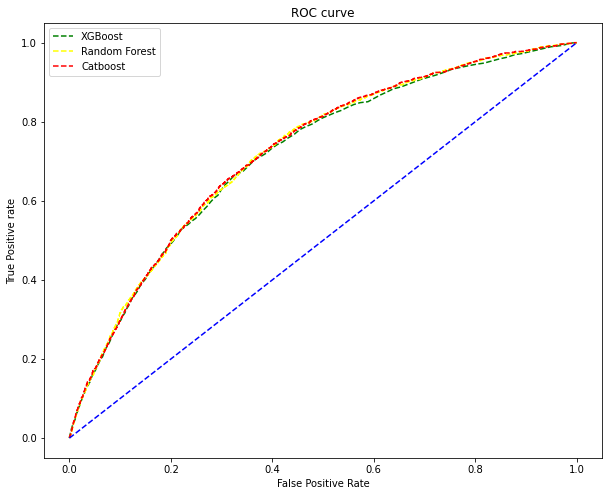

In [ ]:
plt.figure(figsize=(10,8))
#plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='XGBoost')
plt.plot(fpr3, tpr3, linestyle='--',color='yellow', label='Random Forest')
plt.plot(fpr1, tpr1, linestyle='--',color='red', label='Catboost')

plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

### Feature importance

In [ ]:
feature_imp = pd.Series(cat.feature_importances_, index = x_train.columns).sort_values(ascending = False)
feature_df = pd.DataFrame(feature_imp)
feature_df['features'] = feature_df.index
feature_df.reset_index(drop = True, inplace = True)
feature_df.rename(columns = {0: 'weight'},inplace = True)
feature_df = feature_df[['features', 'weight']]

In [ ]:
feature_df.head(10)

,features,weight
0,vehicleModelYear,33.521284
1,originalInterestRatePercentage,13.491534
2,ltv,8.041333
3,vehicleNewUsedCodeM,7.206139
4,vehicleValueAmount,5.090040
5,paymentToIncomePercentage,4.508514
6,obligorCreditScore,4.452202
7,eventYear,3.691511
8,originalLoanTerm,2.590341
9,"obligorIncomeVerificationLevelCodeM_stated,verifiedbutnottolevel4orlevel5",2.021788


### Export

In [ ]:
# model
model_folder = '/content/drive/MyDrive/Loan_default/model/'
m_dir = os.path.isdir(model_folder)
if m_dir == False:
    os.mkdir(model_folder)
    
model_file = 'outcome_model_ct.pkl'
pickle.dump(cat, open(model_folder + model_file, 'wb'))

In [ ]:
# features
json_folder = '/content/drive/MyDrive/Loan_default/features/'
j_dir = os.path.isdir(json_folder)
if j_dir == False:
    os.mkdir(json_folder)
json_file = 'ml_features.json'
json_path = json_folder + json_file
with open(json_path, 'w') as outfile:  
    json.dump(features, outfile, indent = 4, separators = (',', ': '), sort_keys = False)
    

In [ ]:
print('complete...')

complete...
